In [ ]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import operator

from collections import namedtuple, deque
from numpy.random import choice

import time

import matplotlib.pyplot as plt

from IPython import display as ipythondisplay

#from pyvirtualdisplay import Display

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make("LunarLander-v2")

     |████████████████████████████████| 448 kB 8.2 MB/s 


In [ ]:
BUFFER_SIZE = int(1e5)      # replay buffer size
BATCH_SIZE = 64             # minibatch size
GAMMA = 0.99                # discount factor
TAU = 1e-3                  # for soft update of target parameters
LR = 5e-4                   # learning rate 
UPDATE_NN_EVERY = 1        # how often to update the network


In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)

        

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, experiences_per_sampling, seed, compute_weights):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            experiences_per_sampling (int): number of experiences to sample during a sampling iteration
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experiences_per_sampling = experiences_per_sampling
        
        self.alpha = 0.5
        self.alpha_decay_rate = 0.99
        self.beta = 0.5
        self.beta_growth_rate = 1.001
        self.seed = random.seed(seed)
        self.compute_weights = compute_weights
        self.experience_count = 0
        
        self.experience = namedtuple("Experience", 
            field_names=["state", "action", "reward", "next_state", "done"])
        self.data = namedtuple("Data", 
            field_names=["priority", "probability", "weight","index"])

        indexes = []
        datas = []
        for i in range(buffer_size):
            indexes.append(i)
            d = self.data(0,0,0,i)
            datas.append(d)
        
        self.memory = {key: self.experience for key in indexes}
        self.memory_data = {key: data for key,data in zip(indexes, datas)}
        self.sampled_batches = []
        self.current_batch = 0
        self.priorities_sum_alpha = 0
        self.priorities_max = 1
        self.weights_max = 1
    
    def update_priorities(self, tds, indices):
        for td, index in zip(tds, indices):
            N = min(self.experience_count, self.buffer_size)

            updated_priority = td[0]
            if updated_priority > self.priorities_max:
                self.priorities_max = updated_priority
            
            if self.compute_weights:
                updated_weight = ((N * updated_priority)**(-self.beta))/self.weights_max
                if updated_weight > self.weights_max:
                    self.weights_max = updated_weight
            else:
                updated_weight = 1

            old_priority = self.memory_data[index].priority
            self.priorities_sum_alpha += updated_priority**self.alpha - old_priority**self.alpha
            updated_probability = td[0]**self.alpha / self.priorities_sum_alpha
            data = self.data(updated_priority, updated_probability, updated_weight, index) 
            self.memory_data[index] = data

    def update_memory_sampling(self):
        """Randomly sample X batches of experiences from memory."""
        # X is the number of steps before updating memory
        self.current_batch = 0
        values = list(self.memory_data.values())
        random_values = random.choices(self.memory_data, 
                                       [data.probability for data in values], 
                                       k=self.experiences_per_sampling)
        self.sampled_batches = [random_values[i:i + self.batch_size] 
                                    for i in range(0, len(random_values), self.batch_size)]

    def update_parameters(self):
        self.alpha *= self.alpha_decay_rate
        self.beta *= self.beta_growth_rate
        if self.beta > 1:
            self.beta = 1
        N = min(self.experience_count, self.buffer_size)
        self.priorities_sum_alpha = 0
        sum_prob_before = 0
        for element in self.memory_data.values():
            sum_prob_before += element.probability
            self.priorities_sum_alpha += element.priority**self.alpha
        sum_prob_after = 0
        for element in self.memory_data.values():
            probability = element.priority**self.alpha / self.priorities_sum_alpha
            sum_prob_after += probability
            weight = 1
            if self.compute_weights:
                weight = ((N *  element.probability)**(-self.beta))/self.weights_max
            d = self.data(element.priority, probability, weight, element.index)
            self.memory_data[element.index] = d
        print("sum_prob before", sum_prob_before)
        print("sum_prob after : ", sum_prob_after)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.experience_count += 1
        index = self.experience_count % self.buffer_size

        if self.experience_count > self.buffer_size:
            temp = self.memory_data[index]
            self.priorities_sum_alpha -= temp.priority**self.alpha
            if temp.priority == self.priorities_max:
                self.memory_data[index].priority = 0
                self.priorities_max = max(self.memory_data.items(), key=operator.itemgetter(1)).priority
            if self.compute_weights:
                if temp.weight == self.weights_max:
                    self.memory_data[index].weight = 0
                    self.weights_max = max(self.memory_data.items(), key=operator.itemgetter(2)).weight

        priority = self.priorities_max
        weight = self.weights_max
        self.priorities_sum_alpha += priority ** self.alpha
        probability = priority ** self.alpha / self.priorities_sum_alpha
        e = self.experience(state, action, reward, next_state, done)
        self.memory[index] = e
        d = self.data(priority, probability, weight, index)
        self.memory_data[index] = d
            
    def sample(self):
        sampled_batch = self.sampled_batches[self.current_batch]
        self.current_batch += 1
        experiences = []
        weights = []
        indices = []
        
        for data in sampled_batch:
            experiences.append(self.memory.get(data.index))
            weights.append(data.weight)
            indices.append(data.index)

        states = torch.from_numpy(
            np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(
            np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, weights, indices)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

cpu


In [ ]:
# prioritized experience replay
UPDATE_MEM_EVERY = 20          # how often to update the priorities
UPDATE_MEM_PAR_EVERY = 3000     # how often to update the hyperparameters
EXPERIENCES_PER_SAMPLING = math.ceil(BATCH_SIZE * UPDATE_MEM_EVERY / UPDATE_NN_EVERY)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, compute_weights = False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.compute_weights = compute_weights

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.criterion = nn.MSELoss()

        # Replay memory
        self.memory = ReplayBuffer(
            action_size, BUFFER_SIZE, BATCH_SIZE, EXPERIENCES_PER_SAMPLING, seed, compute_weights)
        # Initialize time step (for updating every UPDATE_NN_EVERY steps)
        self.t_step_nn = 0
        # Initialize time step (for updating every UPDATE_MEM_PAR_EVERY steps)
        self.t_step_mem_par = 0
        # Initialize time step (for updating every UPDATE_MEM_EVERY steps)
        self.t_step_mem = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_NN_EVERY time steps.
        self.t_step_nn = (self.t_step_nn + 1) % UPDATE_NN_EVERY
        self.t_step_mem = (self.t_step_mem + 1) % UPDATE_MEM_EVERY
        self.t_step_mem_par = (self.t_step_mem_par + 1) % UPDATE_MEM_PAR_EVERY
        if self.t_step_mem_par == 0:
            self.memory.update_parameters()
        if self.t_step_nn == 0:
            # If enough samples are available in memory, get random subset and learn
            if self.memory.experience_count > EXPERIENCES_PER_SAMPLING:
                sampling = self.memory.sample()
                self.learn(sampling, GAMMA)
        if self.t_step_mem == 0:
            self.memory.update_memory_sampling()

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, sampling, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            sampling (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, weights, indices  = sampling

        ## TODO: compute and minimize the loss        
        q_target = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        expected_values = rewards + gamma*q_target*(1-dones)
        output = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(output, expected_values)
        if self.compute_weights:
            with torch.no_grad():
                weight = sum(np.multiply(weights, loss.data.cpu().numpy()))
            loss *= weight
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        # ------------------- update priorities ------------------- #
        delta = abs(expected_values - output.detach()).numpy()
        #print("delta", delta)      
        self.memory.update_priorities(delta, indices)  

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Episode 30	Average Score: -174.50sum_prob before 1.0280989276355106
sum_prob after :  1.0000000000000013
Episode 58	Average Score: -148.69sum_prob before 1.0172098507122156
sum_prob after :  1.0000000000000018
Episode 83	Average Score: -139.31sum_prob before 1.0191777239413244
sum_prob after :  1.000000000000001
Episode 100	Average Score: -133.18
Duration:  56.14705491065979
Episode 110	Average Score: -120.89sum_prob before 1.010158153980484
sum_prob after :  0.9999999999999911
Episode 133	Average Score: -111.59sum_prob before 1.013666820314572
sum_prob after :  0.9999999999999978
Episode 151	Average Score: -109.85sum_prob before 1.0134120835267646
sum_prob after :  0.9999999999999961
Episode 170	Average Score: -101.68sum_prob before 1.0148759711769637
sum_prob after :  0.9999999999999971
Episode 181	Average Score: -100.01sum_prob before 1.0157087085007719
sum_prob after :  1.000000000000004
Episode 194	Average Score: -97.43sum_prob before 1.0195171041863296
sum_prob after :  1.0000000

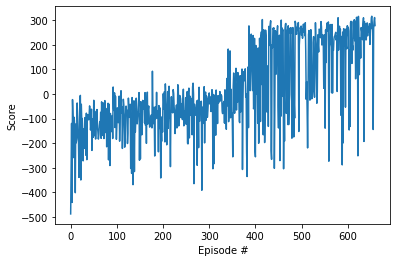

In [ ]:
# train agent

env = gym.make('LunarLander-v2')
env.seed(0)

agent = Agent(state_size=8, action_size=4, seed=0)

def dqn(n_episodes=1000, max_t=2000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    start_time = time.time()

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            elapsed_time = time.time() - start_time
            print("Duration: ", elapsed_time)
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    elapsed_time = time.time() - start_time
    print("Training duration: ", elapsed_time)
    return scores


scores = dqn()


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('training_result.png')